# Semantic Segmentation HomeWork

In [31]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 5.2 MB 29.3 MB/s 


In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from keras.layers import *
from tensorflow import keras
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split
import cv2
from tensorflow_examples.models.pix2pix import pix2pix

Download the pet dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLCK1B7/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLCK1B7/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
image_shape = info.features['image'].shape

In [4]:
print(image_shape)

(None, None, 3)


# **U_NET:**

# Part A: Without using Data Augmentation

In [33]:
# Define a function to preprocess the data
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [34]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [35]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [36]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [37]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [40]:
# loading pre trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu',
         'block_13_expand_relu', 'block_16_expand_relu']
layers = [base_model.get_layer(name).output for name in names]

down_sample = tf.keras.Model(base_model.input, layers)
down_sample.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [41]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [42]:
inputs = tf.keras.layers.Input(shape=[128,128,3 ])
x = inputs

# Downsampling through the model
skips = down_sample(x)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
x = tf.keras.layers.Conv2DTranspose(3, 3, strides=2 , padding='same')(x)  #64x64 -> 128x128

model = tf.keras.Model(inputs, x)

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

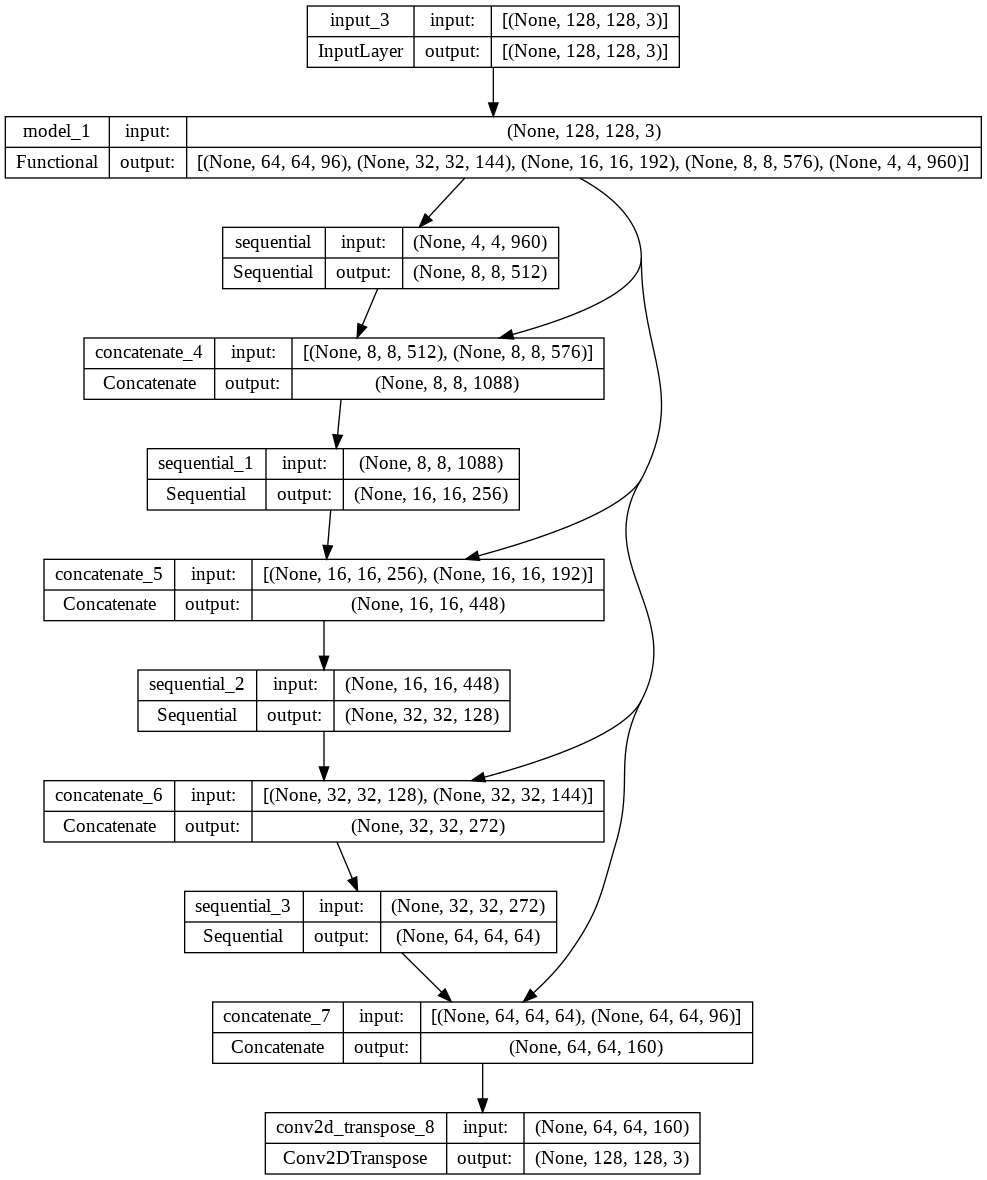

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [50]:
EPOCHS =  20

h = model.fit(train_dataset, 
              epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=test_dataset,
              )

Epoch 1/20
57/57 [==============================] - 17s 294ms/step - loss: 0.2177 - accuracy: 0.9064 - val_loss: 0.3145 - val_accuracy: 0.8731
Epoch 2/20
57/57 [==============================] - 17s 298ms/step - loss: 0.2042 - accuracy: 0.9114 - val_loss: 0.2828 - val_accuracy: 0.8870
Epoch 3/20
57/57 [==============================] - 17s 295ms/step - loss: 0.1902 - accuracy: 0.9166 - val_loss: 0.2797 - val_accuracy: 0.8896
Epoch 4/20
57/57 [==============================] - 17s 290ms/step - loss: 0.1772 - accuracy: 0.9215 - val_loss: 0.3018 - val_accuracy: 0.8834
Epoch 5/20
57/57 [==============================] - 17s 292ms/step - loss: 0.1707 - accuracy: 0.9240 - val_loss: 0.2970 - val_accuracy: 0.8873
Epoch 6/20
57/57 [==============================] - 18s 317ms/step - loss: 0.1583 - accuracy: 0.9290 - val_loss: 0.3134 - val_accuracy: 0.8848
Epoch 7/20
57/57 [==============================] - 18s 318ms/step - loss: 0.1522 - accuracy: 0.9314 - val_loss: 0.3036 - val_accuracy: 0.8893

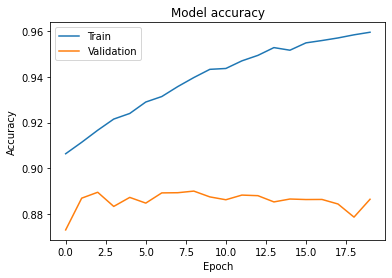

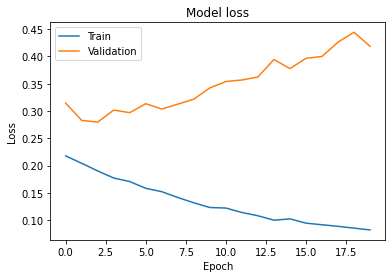

In [51]:
# Plot the accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

58/58 [==============================] - 9s 155ms/step - loss: 0.4186 - accuracy: 0.8865
Test loss: 0.41862520575523376
Test accuracy: 0.8865050077438354


# Part B

# Preprocessing data


In [5]:
NUM_EPOCHS = 30
image_size = 128

In [6]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (image_size, image_size), method="nearest")
   input_mask = tf.image.resize(input_mask, (image_size, image_size), method="nearest")
   return input_image, input_mask

In [7]:
def augment(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:

    # your code here #
    # write suitable Augmentation transforms

    # Flip images horizontally
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    
  return input_image, input_mask

In [8]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [9]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [10]:
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [11]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [13]:
# Retrieve a batch of images from the train_batches dataset
images, _ = next(iter(train_batches))

# Check the shape of the first image in the batch
print(images[0].shape)


(128, 128, 3)


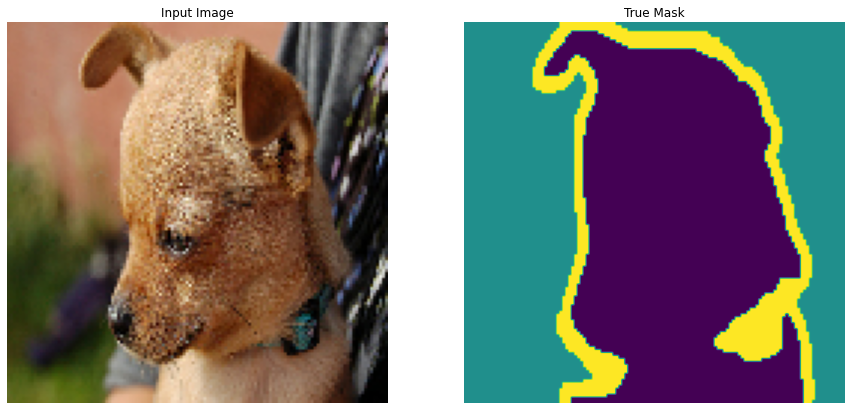

In [14]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

# UNet Architecture
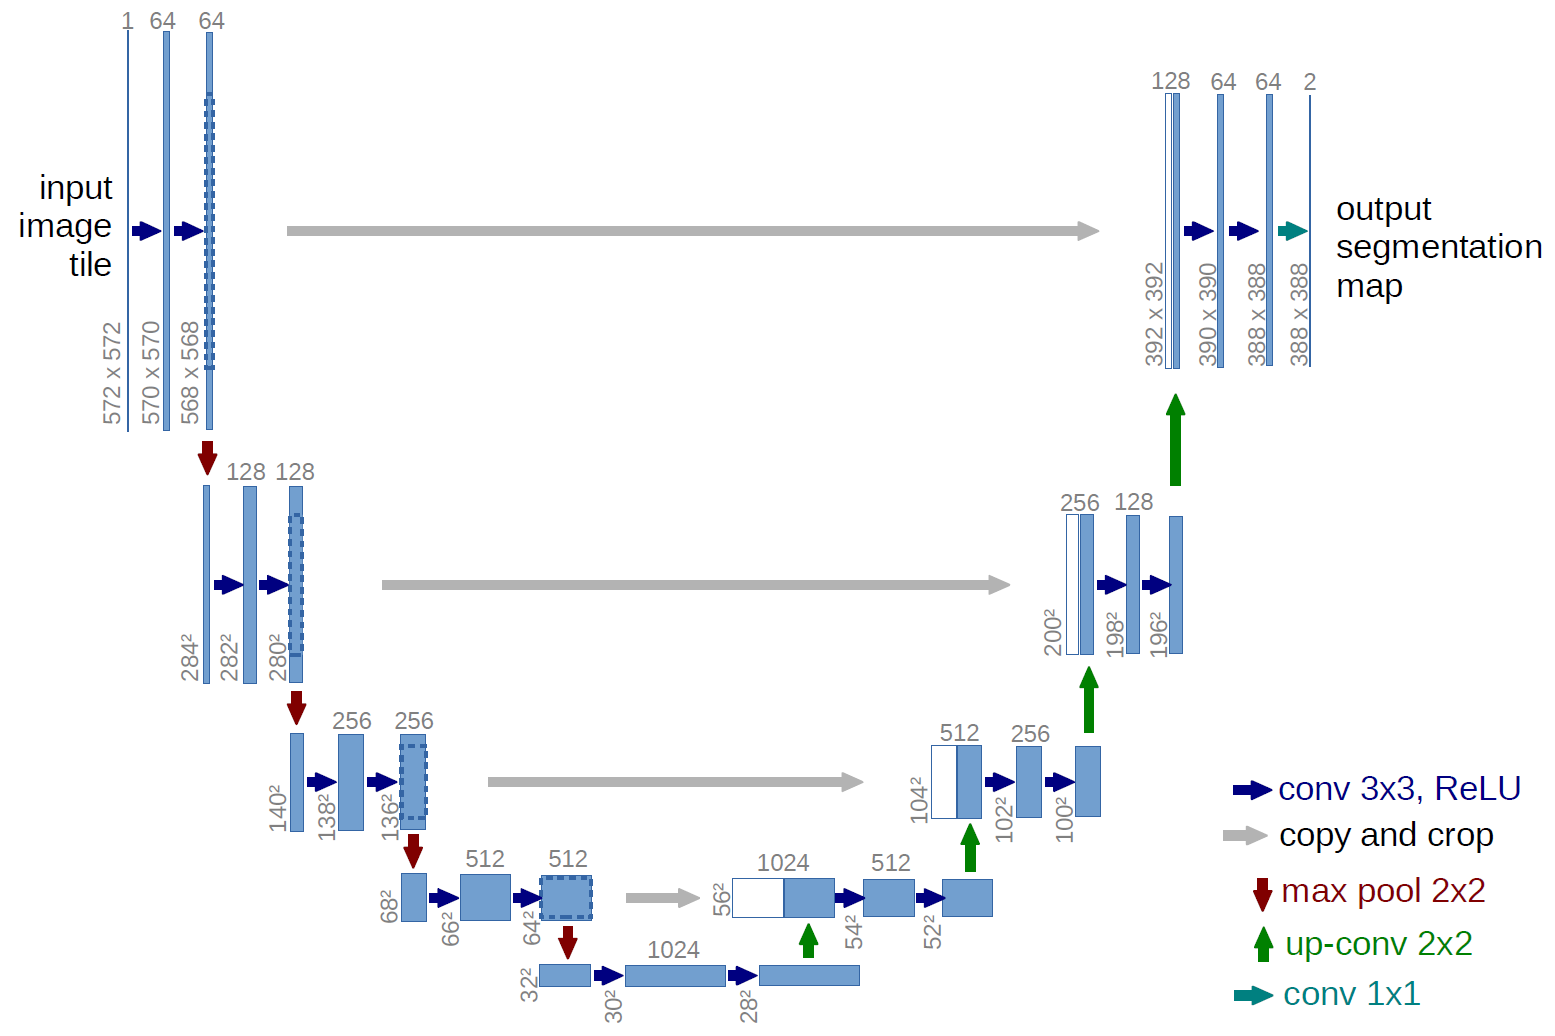



You can use the following link to get acquainted with convolution2d_transpose:


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

In this part:

1.   Design UNet Encoder-Decoder model layer by layer with Keras tool
2.   Compile your model
3.   Train model, show and plot accuracy and loss
4.   display some of predicted masks beside related true masks

Notes:

Use Adam optimizer with learning rate 0.001 and sparse_categorical_crossentropy as loss function

Set accuracy for metrics


In [15]:
# The Encoder is being implemented. The conv2d_block function is defined, 
#which performs convolution twice in each block and has an overlapping part. 
#The encoder_block, which includes a pooling layer, is also defined. 
#A dropout layer is added after the pooling layer for regularization.
#the conv layer has no padding, but it is set to 'same' for convenience.
 
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    '''
    Add 2 convolutional layers with the parameters
    '''
 
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                                   kernel_initializer='he_normal', activation='relu', padding='same')(x)
    return x
 
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Add 2 convolutional blocks and then perform down sampling on output of convolutions
    '''
 
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
 
    return f, p
 
def encoder(inputs):
    '''
    defines the encoder or downsampling path.
    '''
    
    f1, p1 = encoder_block(inputs, n_filters=64)
    f2, p2 = encoder_block(p1, n_filters=128)
    f3, p3 = encoder_block(p2, n_filters=256)
    f4, p4 = encoder_block(p3, n_filters=512)
 
    return p4, (f1, f2, f3, f4)

In [16]:
# Bridge between the encoder and decoder
def Bridge(inputs):
    bridge = conv2d_block(inputs, n_filters=1024)
    return bridge

In [17]:
# The Decoder is defined. 
# In the decoder_block, the inputs are upsampled through Conv2DTranspose, 
# the output of the encoder is concatenated, and then convolution is performed twice.

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet
    '''
 
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters)
 
    return c
 
def decoder(inputs, convs, output_channels):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 
    '''
 
    f1, f2, f3, f4 = convs
 
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
 
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(c9)
 
    return outputs

In [18]:
#Finally, the functions that make up UNet will be assembled and a model will be created. 
#The model will have three labels to classify: Pet/Outline/Background, 
#the final output will have a shape of 128x128x3.
OUTPUT_CHANNELS = 3
 
def UNet():
    '''
    Defines the UNet by connecting the encoder, bridge and decoder
    '''
 
    inputs = tf.keras.layers.Input(shape=(128,128,3,))
 
    encoder_output, convs = encoder(inputs)
    bridge = Bridge(encoder_output)
    outputs = decoder(bridge, convs, OUTPUT_CHANNELS)
 
    model = tf.keras.Model(inputs, outputs)
 
    return model

In [19]:
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [21]:
# configure the training parameters and train the model
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [22]:
# this will take around 20 minutes to run
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_batches)

Epoch 1/20
57/57 [==============================] - 83s 999ms/step - loss: 0.9971 - acc: 0.5779 - val_loss: 0.8691 - val_acc: 0.6429
Epoch 2/20
57/57 [==============================] - 63s 982ms/step - loss: 0.7558 - acc: 0.6908 - val_loss: 0.6807 - val_acc: 0.7226
Epoch 3/20
57/57 [==============================] - 55s 975ms/step - loss: 0.6648 - acc: 0.7294 - val_loss: 0.6616 - val_acc: 0.7374
Epoch 4/20
57/57 [==============================] - 55s 975ms/step - loss: 0.6128 - acc: 0.7529 - val_loss: 0.5873 - val_acc: 0.7648
Epoch 5/20
57/57 [==============================] - 55s 974ms/step - loss: 0.5696 - acc: 0.7740 - val_loss: 0.5595 - val_acc: 0.7861
Epoch 6/20
57/57 [==============================] - 56s 983ms/step - loss: 0.5181 - acc: 0.7977 - val_loss: 0.4962 - val_acc: 0.8073
Epoch 7/20
57/57 [==============================] - 55s 974ms/step - loss: 0.4840 - acc: 0.8121 - val_loss: 0.4518 - val_acc: 0.8260
Epoch 8/20
57/57 [==============================] - 56s 976ms/step - 

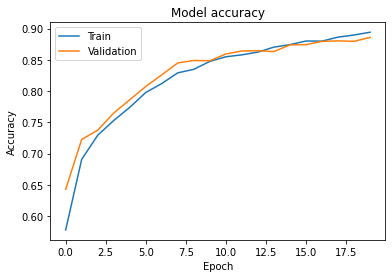

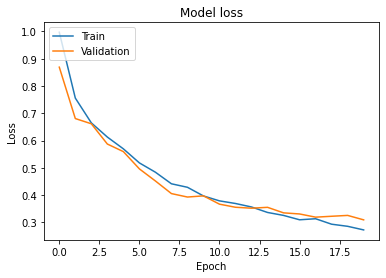

In [25]:
# Plot the accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_batches)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

11/11 [==============================] - 15s 676ms/step - loss: 0.3194 - acc: 0.8819
Test loss: 0.31935834884643555
Test accuracy: 0.88189297914505


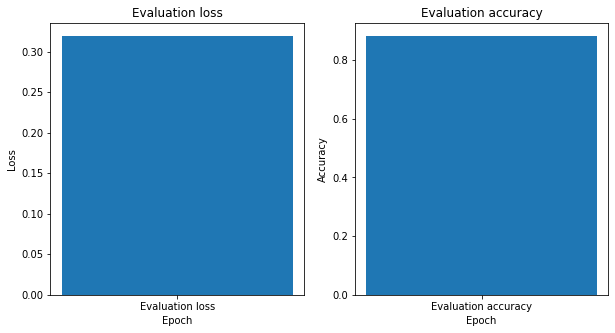

In [29]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the loss on the first subplot
ax[0].bar(['Evaluation loss'], [test_loss])
ax[0].set_title('Evaluation loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')

# Plot the accuracy on the second subplot
ax[1].bar(['Evaluation accuracy'], [test_acc])
ax[1].set_title('Evaluation accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

plt.show()


# Result Comparison on part A and B

In summary, using data augmentation in the U-Net model led to a lower test loss and a slightly lower test accuracy compared to not using data augmentation.

**Results without Data Augmentation**

Test loss: 0.41862520575523376

Test accuracy: 0.8865050077438354

**Results with Data Augmentation**

Test loss: 0.31935834884643555

Test accuracy: 0.88189297914505

# C:
Display the predicted output and true mask for some of the test images in part b.

2/2 [==============================] - 0s 194ms/step


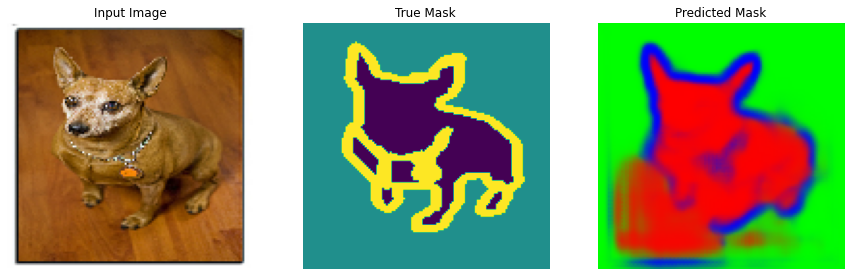

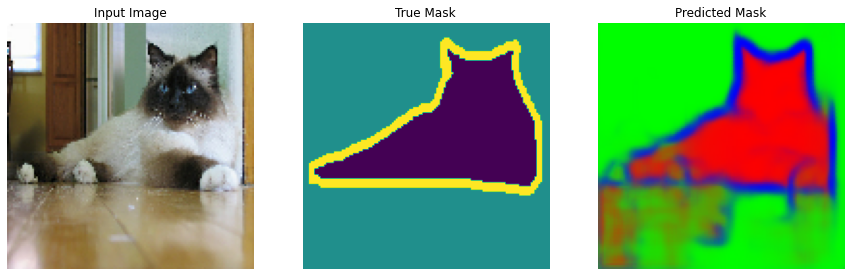

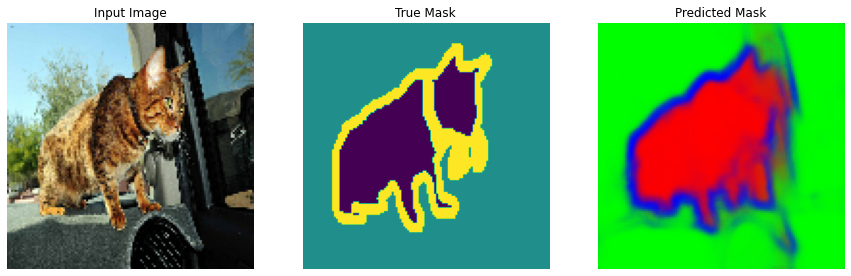

In [30]:
# Get a batch of test data
test_batch = next(iter(test_batches))

# Get the images and masks from the test batch
images = test_batch[0]
masks = test_batch[1]

# Predict the masks using the model
predictions = model.predict(images)

# Display a few images and masks
display([images[0], masks[0], predictions[0]])
display([images[1], masks[1], predictions[1]])
display([images[2], masks[2], predictions[2]])

# D
In the coder part of the UNet model, use a trained network, form the new model proportionally, train the model, report the accuracy and loss of training and testing at each stage of training and draw them. . Analyze the result. You can use Resnet-50.

In [53]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [54]:
input_shape = (128, 128, 3)
model_unetR50 = build_unet(input_shape)
model_unetR50.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 128, 128, 64  256        ['conv2d_19[0][0]']              
 rmalization)                   )                                                             

In [55]:
model_unetR50.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [57]:
history = model_unetR50.fit(train_batches, epochs=5,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_batches)

Epoch 1/5
57/57 [==============================] - 47s 816ms/step - loss: nan - acc: 0.2996 - val_loss: nan - val_acc: 0.3019
Epoch 2/5
57/57 [==============================] - 47s 821ms/step - loss: nan - acc: 0.2996 - val_loss: nan - val_acc: 0.3019
Epoch 3/5
57/57 [==============================] - 47s 812ms/step - loss: nan - acc: 0.2996 - val_loss: nan - val_acc: 0.3019
Epoch 4/5
57/57 [==============================] - 47s 819ms/step - loss: nan - acc: 0.2996 - val_loss: nan - val_acc: 0.3019
Epoch 5/5
57/57 [==============================] - 47s 810ms/step - loss: nan - acc: 0.2996 - val_loss: nan - val_acc: 0.3019


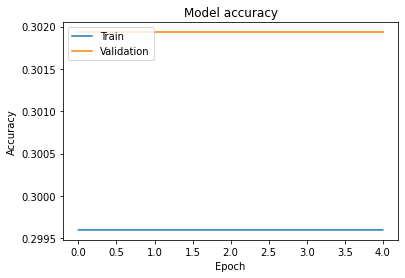

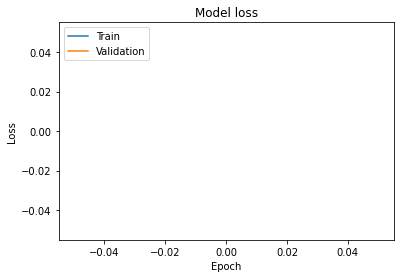

In [58]:
# Plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [60]:
# Evaluate the model on the test data
test_loss, test_acc = model_unetR50.evaluate(test_batches)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

11/11 [==============================] - 14s 399ms/step - loss: nan - acc: 0.2935
Test loss: nan
Test accuracy: 0.29353979229927063


# References

https://www.tensorflow.org/tutorials/images/segmentation

https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/segmentation_unet-three-plus_oxford-iiit.ipynb

https://github.com/anantgupta129/Image-Segmentation-Using-Pets-Dataset

https://junstar92.tistory.com/151

https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/unet.py

https://towardsdatascience.com/image-segmentation-unet-and-deep-supervision-loss-using-keras-model-f21a9856750a

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/